# **1.** **Importing Modeling** & **Feature Engineering** liberaries

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## **1.1.** Setting style to **ggplot**

In [2]:
plt.style.use('ggplot')
%matplotlib inline

## **1.2.** Setting plot **Size**, **Font** & **Mode**

In [3]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font' , **font)
plt.rcParams['savefig.dpi'] = 480
plt.rcParams["figure.figsize"] = (40, 30)

# **2.** Importing Data to **DataFram**

In [4]:
train_df = pd.read_csv("./resources/originalData/train.csv").drop(columns='ID')
test_df = pd.read_csv("./resources/originalData/test.csv").drop(columns='ID')
train_data_count = train_df.count()[0]
print("Train data samples count:",train_data_count)

Train data samples count: 10834


## **2.1. Merging DataFrams**

In [5]:
train_data_count = train_df.count()
dry_bean_df = pd.concat([train_df,test_df],axis=0)
dry_bean_y_df = dry_bean_df['y']
dry_bean_x_df = dry_bean_df.drop(columns=['y'])

# **3.** Feature Engineering

## 3.1 Standardization

In [6]:
standered_scaler = StandardScaler()
train_standardized = standered_scaler.fit_transform(train_df.drop(columns='y'))
test_standardized = standered_scaler.transform(test_df)

## **3.2.** PCA

In [7]:
pca = PCA(n_components=9)
pca_x_data = pca.fit_transform(train_standardized)

In [8]:
pca_df = pd.concat([pd.DataFrame(pca_x_data),train_df['y']],axis=1)

## **3.3.** T-SNE

In [9]:
X_embedded = TSNE(n_components=3,perplexity=30, learning_rate=200, n_iter=1000).fit_transform(train_df.drop(columns='y'))

In [10]:
tsne_df = pd.DataFrame(X_embedded,columns=["axis1","axis2",'axis3'])

### Construct **train** dataframe from **tsne** and **pca**

In [11]:
train_transformed =  pd.concat([pca_df,tsne_df],axis=1).drop(columns='y')

In [12]:
train_transformed.sample(1)

,0,1,2,3,4,5,6,7,8,axis1,axis2,axis3
176,10.38203,4.995637,-0.751842,0.477124,-0.98363,1.367253,0.956637,0.112443,-0.367848,22.43154,6.051641,10.41074


## **3.4.** Balance clases

In [13]:
train_df.y.unique().tolist()

['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY']

In [14]:
weights = dict(zip(train_df.y.unique(),[4000,4000,8000,8000,4000,4000,4000]))

In [15]:
smote = SMOTE(sampling_strategy=weights)
x_smote_balance,y_smote_balance = smote.fit_resample(train_transformed,train_df['y'])

D:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (4000) in class HOROZ will be larger than the number of samples in the majority class (class #DERMASON -> 2837)
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (4000) in class SEKER will be larger than the number of samples in the majority class (class #DERMASON -> 2837)
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (8000) in class DERMASON will be larger than the number of samples in the majority class (class #DERMASON -> 2837)
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (8000) in class SIRA will be larger than the number of samples in the majo

# ***4. SVM Model***

In [16]:
weights = dict(zip(train_df.y.unique(),[1,1,1,1,1,1,1]))

In [17]:
support_vector_machine = SVC(C=5.5, kernel='rbf', degree=3, gamma=3.5, coef0=0.0, shrinking=False, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=42)

## **4.1. K_Fold** evaluation

In [18]:
k_fold = StratifiedKFold(n_splits=30)
scores = cross_validate(support_vector_machine,X=x_smote_balance,y=y_smote_balance,n_jobs=-1,cv=k_fold,scoring=['accuracy'])

In [ ]:
print('Cross Validation Accuracy:',np.mean(scores['test_accuracy']))

Cross Validation Accuracy: 0.9810277777777777


## **4.2. Confusion Matrix** evaluation

In [ ]:
_, x_val, _, y_val = train_test_split(train_transformed,train_df['y'],test_size=0.2,random_state=42)
x_train, _, y_train, _ = train_test_split(x_smote_balance,y_smote_balance,test_size=0.2,random_state=42)

In [ ]:
support_vector_machine.fit(x_train,y_train)
y_pred = support_vector_machine.predict(x_val)

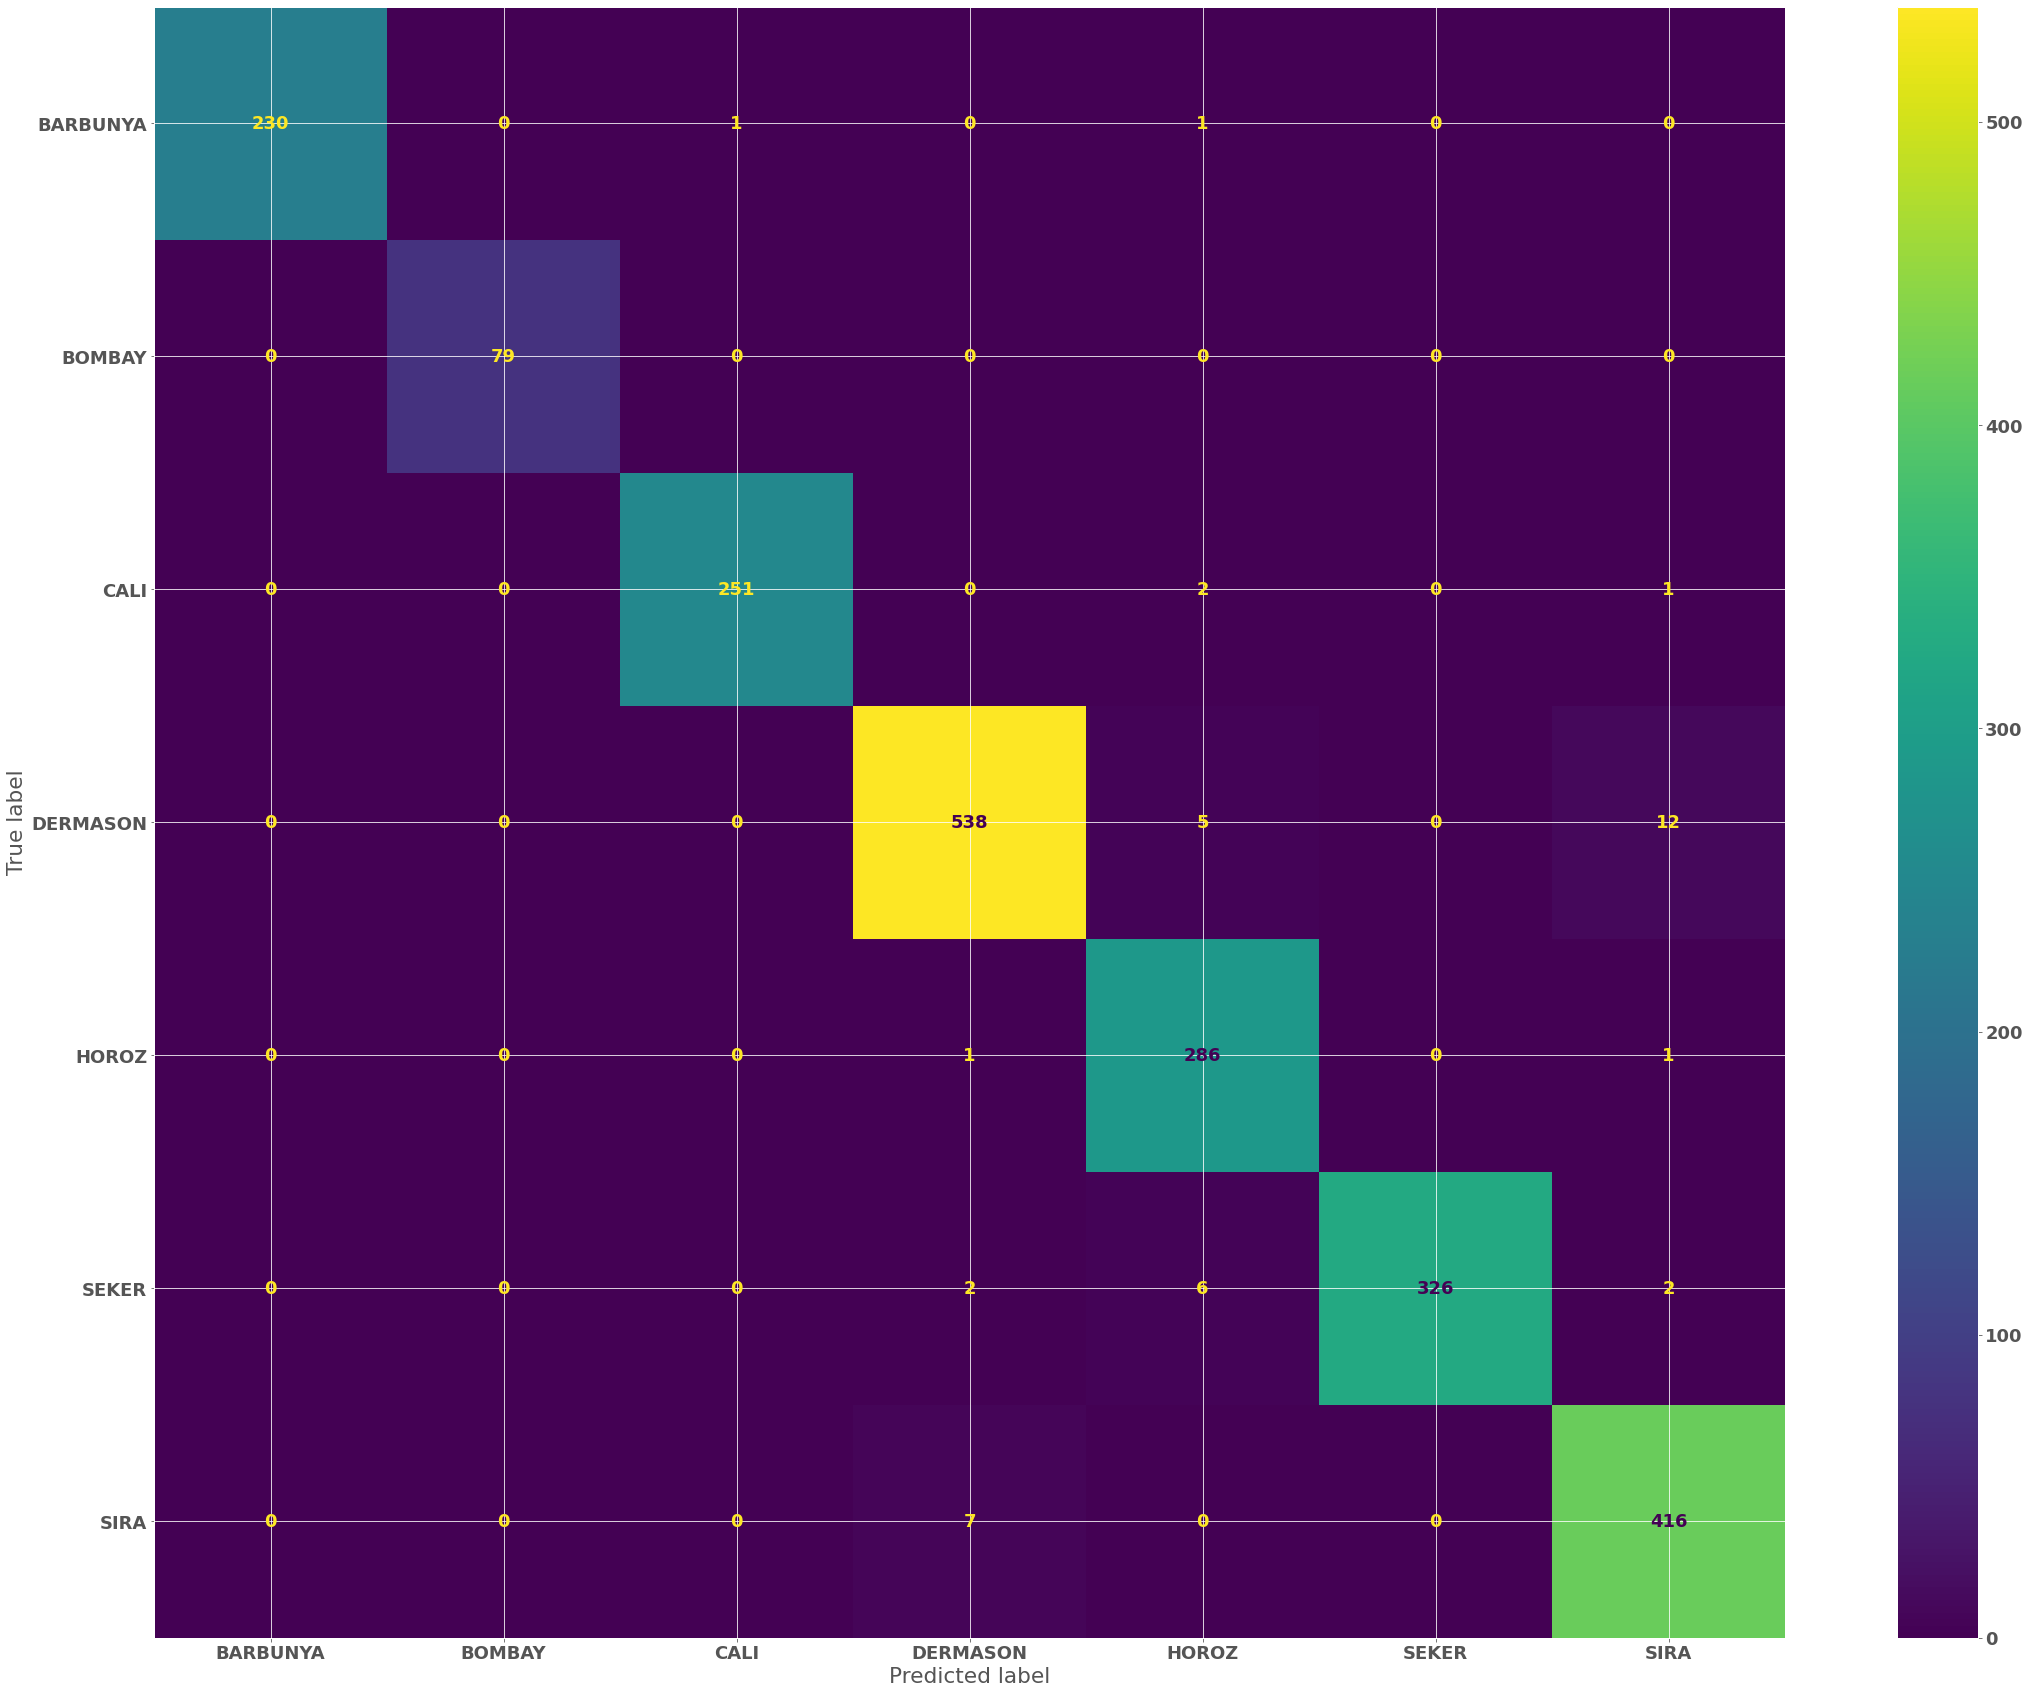

In [ ]:
plot_confusion_matrix(support_vector_machine,x_val,y_val)

In [ ]:
print(classification_report(y_true=y_val,y_pred=y_pred))

              precision    recall  f1-score   support

    BARBUNYA       1.00      0.99      1.00       232
      BOMBAY       1.00      1.00      1.00        79
        CALI       1.00      0.99      0.99       254
    DERMASON       0.98      0.97      0.98       555
       HOROZ       0.95      0.99      0.97       288
       SEKER       1.00      0.97      0.98       336
        SIRA       0.96      0.98      0.97       423

    accuracy                           0.98      2167
   macro avg       0.98      0.99      0.98      2167
weighted avg       0.98      0.98      0.98      2167



# ***5. Observations***

## **First** Observation, Preprocessing (**Standardization**):
* ### Model confused between **Sira** and **Dermason** **70** smaple miss classified
* ### Model confused between **Cali** and **Barbounya** **20** samples miss classified
* ### **Accuracy** score 94% and avarage **Accuracy** 92.77%
* ### Looking to improve **Dermason , Cali and Sira** scores which are the **worest** **F1** scores **93%,93%,89%**

## **Second** Observation, Preprocessing (**Standardization**,**Smote**):
* ### Model confused between **Sira** and **Dermason** **70** smaple miss classified
* ### Model confused between **Cali** and **Barbounya** **20** samples miss classified
* ### **Accuracy** score 94% and avarage **Accuracy** 94.6%
* ### Looking to improve **Dermason , Cali and Sira** scores which are the **worest** **F1** scores **93%,93%,90%**

## **Third** Observation, Preprocessing (**Standardization**,**Smote"[4000,4000,8000,8000,4000,4000,4000]"**):
* ### Model confused between **Sira** and **Dermason** **55** smaple miss classified
* ### Model confused between **Cali** and **Barbounya** **7** samples miss classified
* ### **Accuracy** score 96% and avarage **Accuracy** 96.5%
* ### Looking to improve **Dermason ,Sira** scores which are the **worest** **F1** scores **95%,92%**

## **Fourth** Observation, Preprocessing (**Standardization**,**Smote"[4000,4000,8000,8000,4000,4000,4000]"**,**T-SNE**):
* ### Model confused between **Sira** and **Dermason** **30** smaple miss classified
* ### Model confused between **Cali** and **Barbounya** **7** samples miss classified ***Solved***
* ### **Accuracy** score 98% and avarage **Accuracy** 97.6%
* ### Looking to improve **Dermason ,Sira** scores which are the **worest** **F1** scores **97%,95%**
## **Tuning** {C:2, gamma:3}:
* ### Result **Accuracy** score 98% and mean **Accuracy** 98.0%
* ### Model confused between **Sira** and **Dermason** **19** smaple miss classified
## **Tuning using gridsearch** {C:5.5, gamma:3.5}:
* ### Result **Accuracy** score 98% and mean **Accuracy** 98.0%
* ### Model classify **6 Dermason** as **Sira**
* ### Model classify **8 Horoz** as **Seker**